In [1]:
# Import modelflow

%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from ipywidgets import interact,Dropdown,Checkbox
from IPython.display import display, clear_output,Latex, Markdown
import pandas as pd

import modeljupyter as mj
from modelvis import waterplot

from modelinvert import targets_instruments
from modelclass import model
model.widescreen()



In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
# Load model and data, and run 

if not 'masia' in locals():
    print('Load model')
    masia,baseline = model.modelload('Asia.pcim',run=1,silent=1)
from inject import inject
inject(masia)    

In [6]:
co2_input_var = [var for var in masia.totgraph.predecessors('WLD_CO2') if var.endswith('CO2')]
co2_input_var_asean = [var for var in masia.totgraph.predecessors('WLD_CO2') if var.endswith('CO2') and  var.split('_')[0] in masia.countries_ASEAN ]

In [7]:
co2_baseline = baseline.loc[:,co2_input_var].pipe(lambda df:df.rename(columns={c : masia.iso_dict.get(cname := c.split('_')[0],cname) for c in df.columns}))
co2_baseline_asean = baseline.loc[:,co2_input_var_asean].pipe(lambda df:df.rename(columns={c : masia.iso_dict.get(cname := c.split('_')[0],cname) for c in df.columns}))

In [8]:
# Variables to inputwidget

outvar = 'GDI GCARBR CO2 LNN'.split()
displayvar = 'WLD_CO2 ASP_CO2 G20_CO2 '

#  masia.countries_GCARBR_A is list of all countries in the model with a countries_GCARBR_A 
#  masia.countries_ASEAN is list of all countries in ASEAN 
countries_rest = [country for country in masia.countries_GCARBR_A if country not in masia.countries_ASEAN]

slidedef_allasean =  {'All ASEAN countries' : {'var': ' '.join([f'{country}_GCARBR_A' for country in masia.countries_ASEAN ])
                          , 'value': 0.0,'min':0,'max':100,'op':'+impulse','step':10,'dec':0}}
slidedef_allrest =  {'Rest of the world' : {'var': 
    ' '.join([f'{country}_GCARBR_A' for country in countries_rest])
                          , 'value': 0.0,'min':0,'max':100,'op':'+impulse','step':10,'dec':0}}
slidedef_countries = {masia.iso_dict.get(country,country)+', Extra' : 
                      {'var': f'{country}_GCARBR_A', 'value': 0.0,'min':-40,'max':40,'op':'+impulse','step':10,'dec':0} 
                      for country in  masia.countries_ASEAN}

slidedef = {**slidedef_allasean,**slidedef_allrest,**slidedef_countries}

# World $CO^2$

# ASEAN $CO^2$

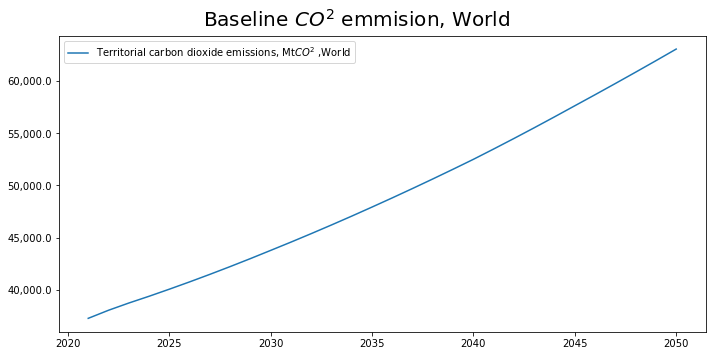

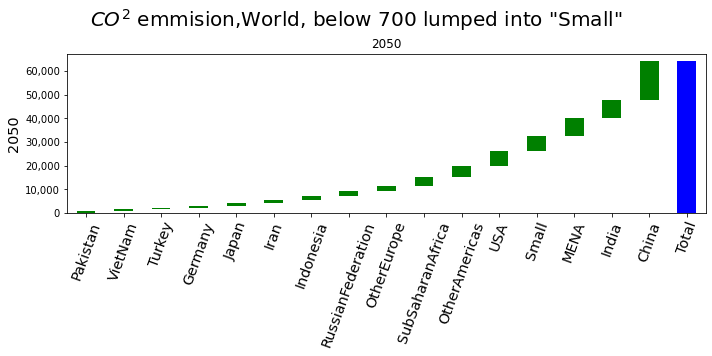

In [9]:
masia['wld_co2'].rename().plot(colrow=1,title='Baseline $CO^2$ emmision, World',top=0.9,ysize=5);

threshold =700
waterplot(co2_baseline.loc[[2050],:].T,autosum=1,threshold = 700,allsort=1,title = f'$CO^2$ emmision,World, below {threshold} lumped into "Small"',top=0.85);

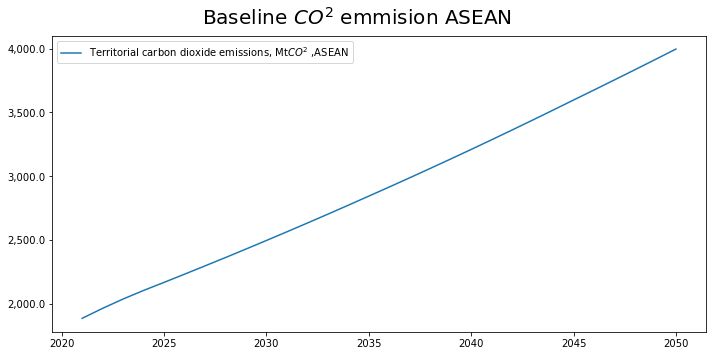

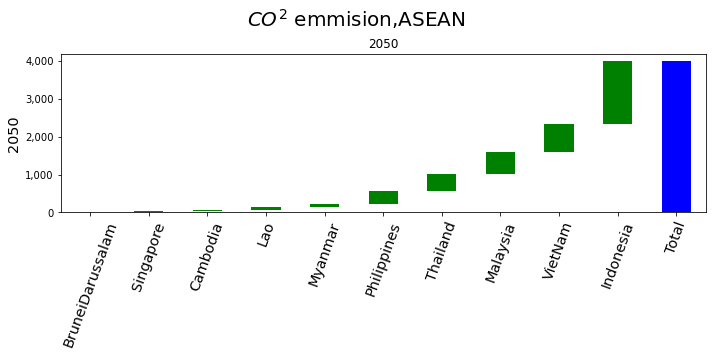

In [10]:
masia['asean_co2'].rename().plot(colrow=1,title='Baseline $CO^2$ emmision ASEAN',top=0.9,ysize=5);

threshold =0.1
waterplot(co2_baseline_asean.loc[[2050],:].T,autosum=1,threshold = 0 ,allsort=1,title = f'$CO^2$ emmision,ASEAN',top=0.85);

# Make some policy 

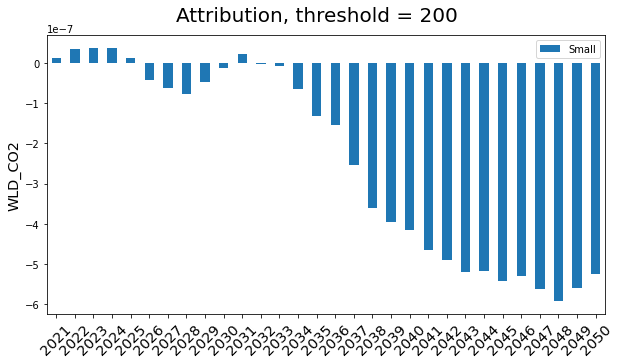

In [21]:
inject(masia)
input = masia.inputwidget_asia(2021,2050,slidedef=slidedef
                   ,showout=True,varpat=displayvar,showvar=True,go_now=1)

# World reduction 

# ASEAN reduction

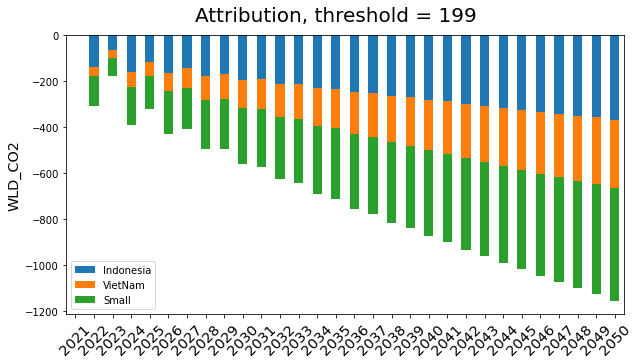

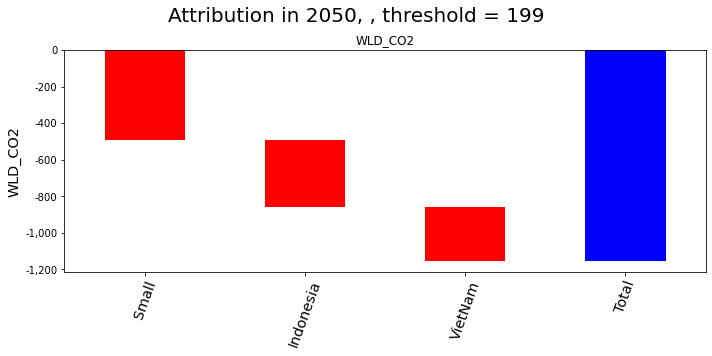

In [17]:
if masia.inputwidget_alternativerun:
    Threshold =199
    masia.dekomp_plot('WLD_CO2',pct=0,threshold=Threshold,nametrans=masia.country_get)
    masia.dekomp_plot_per('WLD_CO2',pct=0,threshold=Threshold,per=2050,sort=True,nametrans=masia.country_get);
else:
    display(Markdown('# Try make an alternative and run again'))

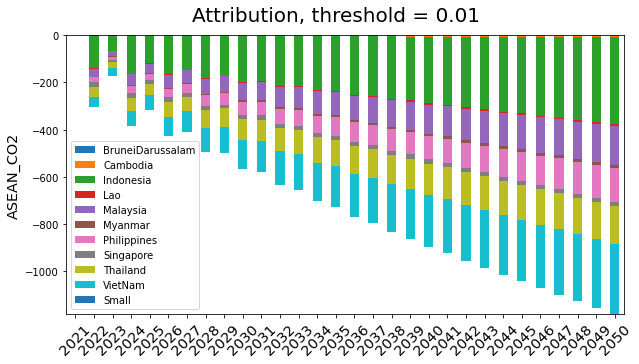

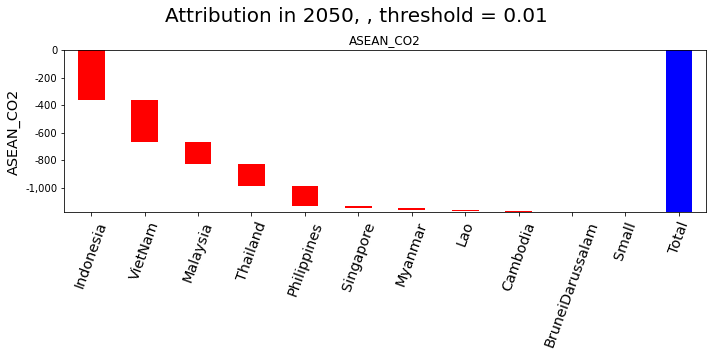

In [18]:
if masia.inputwidget_alternativerun:
    Threshold =0.01
    masia.dekomp_plot('ASEAN_CO2',pct=0,threshold=Threshold,nametrans=masia.country_get)
    masia.dekomp_plot_per('ASEAN_CO2',pct=0,threshold=Threshold,per=2050,sort=True,nametrans=masia.country_get);
else:
    display(Markdown('# Try make an alternative and run again'))

In [ ]:
masia.exodif()

In [ ]:
with masia.set_smpl(2010,2050):
    masia['wld_co2'].rename().plot(colrow=1,title='Baseline $CO^2$ emmision, World',top=0.9,ysize=5);
